In [52]:
from qiskit import QuantumCircuit, QuantumRegister
import os, sys
import numpy
import random
from tqdm import tqdm
import rustworkx
import json
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, partial_trace

if not '../' in sys.path:
    sys.path.insert(1, '../')

In [53]:
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.uncompfunctions import add_uncomputation, exhaustive_uncomputation_adding, greedy_uncomputation_full, greedy_uncomputation_partial
from helperfunctions.graphhelper import edge_attr, edge_matcher,node_attr,node_matcher, breakdown_qubit
from helperfunctions.measurecircuit import get_statevector, get_probability_from_statevector, zero_ancillas_in_statevector
from helperfunctions.constants import UncompType
from helperfunctions.randomcircuit import random_quantum_circuit_large_with_params

from rustworkx.visualization import graphviz_draw

In [54]:
def qubit_shifting_circuit_with_no_uncomp():
    circuit = QuantumCircuit(QuantumRegister(3,'cq'), QuantumRegister(3,'aq'))
    for i in range(3):
        circuit.h(i)
        circuit.cx(i,i+3)
    for i in range(3):
        circuit.cx(i+3,i)

    circuit.cx(3,1)
    circuit.cx(4,2)
    circuit.cx(5,0)

    for i in range(3):
        circuit.h(i)

    return circuit, 3,3,9
    
def qubit_shifting_circuit_with_some_uncomp():
    circuit = QuantumCircuit(QuantumRegister(3,'cq'), QuantumRegister(3,'aq'))
    for i in range(3):
        circuit.h(i)
        circuit.cx(i,i+3)
    # for i in range(3):
    #     circuit.cx(i+3,i)

    circuit.cx(3,1)
    circuit.cx(4,2)
    circuit.cx(5,0)

    circuit.cx(1,0)
    circuit.cx(2,1)
    circuit.cx(5,2)

    for i in range(3):
        circuit.h(i)
    
    return circuit, 3,3,9
    
def static_circuit(theta=0.25):
    circuit = QuantumCircuit(QuantumRegister(3, name='cq'), QuantumRegister(3, name='aq'))
    
    for i in range(3):
        # circuit.rx(theta*numpy.pi, i)
        circuit.h(i)
        # circuit.rx(theta*numpy.pi, i)
        circuit.ry(theta*numpy.pi, i)
        # circuit.rx(theta*numpy.pi/2, i)
    
    circuit.cx(0,3)
    circuit.cx(1,3)
    
    circuit.cz(3,0)
    
    circuit.cx(0,5)
    
    circuit.cx(4,3)
    circuit.cx(3,4)
    
    circuit.cx(1,5)
    circuit.cx(2,3)
    
    circuit.cx(3,4)
    circuit.cx(4,3)
    circuit.cz(5,2)

    for i in range(3):
        circuit.h(i)


    return circuit, 3, 3, 11

Adding Nodes for Circuit: 100%|██████████| 20/20 [00:00<00:00, 86125.34it/s]


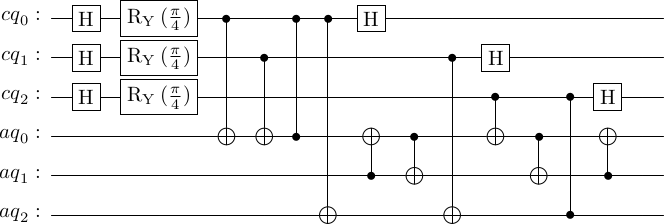

In [55]:
# Change these values for different number of input(q), ancilla(a) and gates(g)
# q = 4
# a = 7 
# g = 40
comp_circuit, q, a, g = static_circuit()
# comp_circuit.draw('latex')
ancillas_list = [breakdown_qubit(q)['label'] for q in comp_circuit.qubits][-a:]
# ancillas = breakdown_qubit
comp_graph = get_computation_graph(comp_circuit, ancillas_list)
comp_circuit.draw('latex')

Checking Out Exhaustive Uncomp for All Ancillas: 8it [00:00, 1324.43it/s]
Building uncomp circuit from circuit graph: 100%|██████████| 28/28 [00:00<00:00, 9762.30it/s]


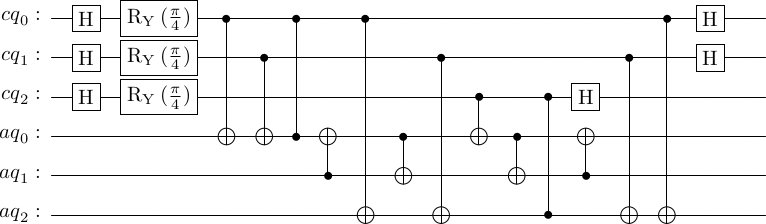

In [56]:
largest_ancilla = exhaustive_uncomputation_adding(comp_graph, ancillas_list)
exhaustive_cg, cycle = add_uncomputation(comp_graph, largest_ancilla)
exhaustive_circuit = get_uncomp_circuit(exhaustive_cg)
exhaustive_circuit.draw('latex')

Iterating over all cycles in graph:   0%|          | 64/100000 [00:00<00:00, 100877.66it/s]


aq0 280


Iterating over all cycles in graph:   0%|          | 5/100000 [00:00<00:03, 32564.47it/s]


aq1 9


Building uncomp circuit from circuit graph: 100%|██████████| 28/28 [00:00<00:00, 34249.20it/s]


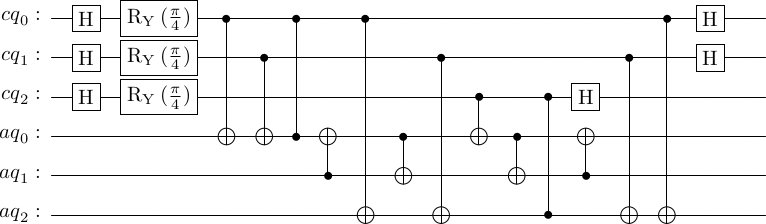

In [57]:
greedy_full_cg = greedy_uncomputation_full(comp_graph, ancillas_list)
greedy_full_circuit = get_uncomp_circuit(greedy_full_cg)
greedy_full_circuit.draw('latex')

Iterating over all cycles:   0%|          | 64/100000 [00:00<00:00, 210372.61it/s]


aq0 280


Building uncomp circuit from circuit graph: 100%|██████████| 32/32 [00:00<00:00, 101834.39it/s]


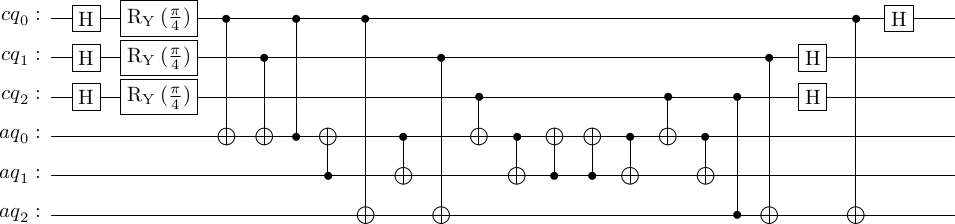

In [58]:
greedy_part_cg = greedy_uncomputation_partial(comp_graph, ancillas_list)
greedy_part_circuit = get_uncomp_circuit(greedy_part_cg)
greedy_part_circuit.draw('latex')

In [59]:
desired_sv = zero_ancillas_in_statevector(Statevector(comp_circuit), a)


In [60]:
from helperfunctions.measurecircuit import get_computation_qubit_probabilty


no_uncomp = get_computation_qubit_probabilty(comp_circuit, range(q))
desired = get_computation_qubit_probabilty(desired_sv,range(q))
exhaustive = get_computation_qubit_probabilty(exhaustive_circuit,range(q))
greedy_full = get_computation_qubit_probabilty(greedy_full_circuit,range(q))
greedy_part = get_computation_qubit_probabilty(greedy_part_circuit,range(q))

In [61]:
print(len(desired_sv))
print(len(desired))

64
8


In [62]:
print(desired)

[3.33333333e-01 1.24967773e-13 1.24967773e-13 3.33333333e-01
 1.24967773e-13 3.33333333e-01 1.24967773e-13 1.24967773e-13]


In [63]:
plot_x = [bin(i)[2:] for i in range(len(no_uncomp))]
plt_dict = {'no_uncomp':[], 'desired':[], 'exhaustive':[], 'greedy_full':[], 'greedy_part':[]}
for i in range(len(plot_x)):
    plt_dict['no_uncomp'].append(no_uncomp[i])
    plt_dict['desired'].append(desired[i])
    plt_dict['exhaustive'].append(exhaustive[i])
    plt_dict['greedy_full'].append(greedy_full[i])
    plt_dict['greedy_part'].append(greedy_part[i])

In [64]:
x = numpy.arange(len(plot_x))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

In [65]:
import pandas as pd

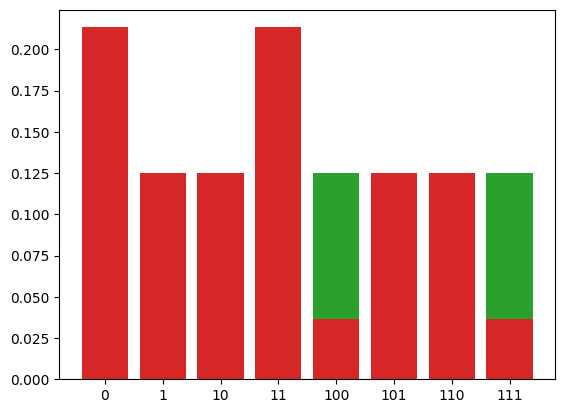

In [66]:
plt.bar(x=plot_x, height=plt_dict['no_uncomp'])
plt.bar(x=plot_x, height=plt_dict['exhaustive'])
plt.bar(x=plot_x, height=plt_dict['greedy_full'])
plt.bar(x=plot_x, height=plt_dict['greedy_part'])

plt.show()

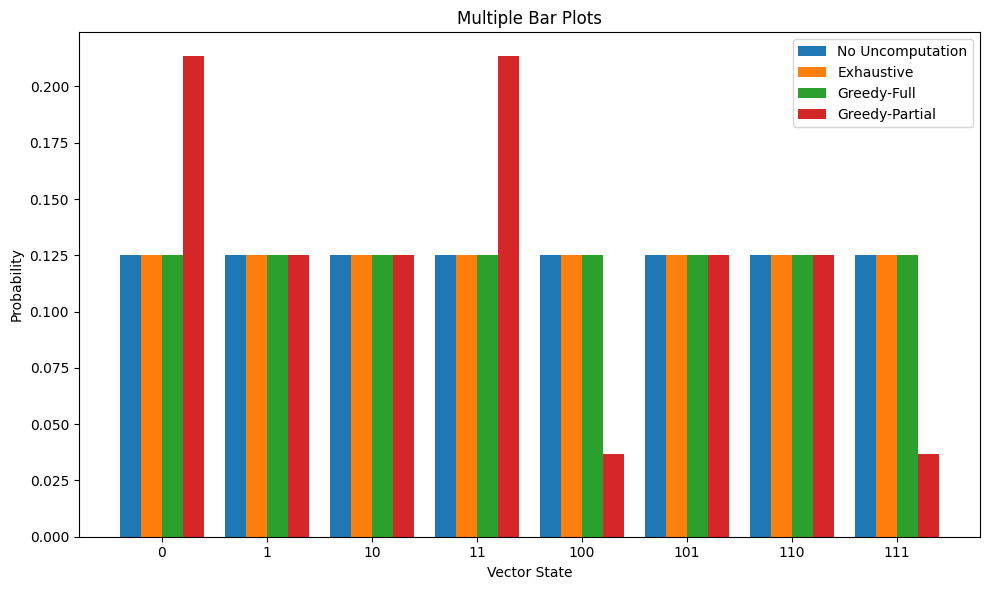

In [67]:
x = numpy.arange(len(plot_x))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5 * width, plt_dict['no_uncomp'], width, label='No Uncomputation')
rects2 = ax.bar(x - 0.5 * width, plt_dict['exhaustive'], width, label='Exhaustive')
rects3 = ax.bar(x + 0.5 * width, plt_dict['greedy_full'], width, label='Greedy-Full')
rects4 = ax.bar(x + 1.5 * width, plt_dict['greedy_part'], width, label='Greedy-Partial')

ax.set_xlabel('Vector State')
ax.set_ylabel('Probability')
ax.set_title('Multiple Bar Plots')
ax.set_xticks(x)
uni_I = ''
uni_K = ''

ax.set_xticklabels([f'{uni_I}{i}{uni_K}' for i in plot_x])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

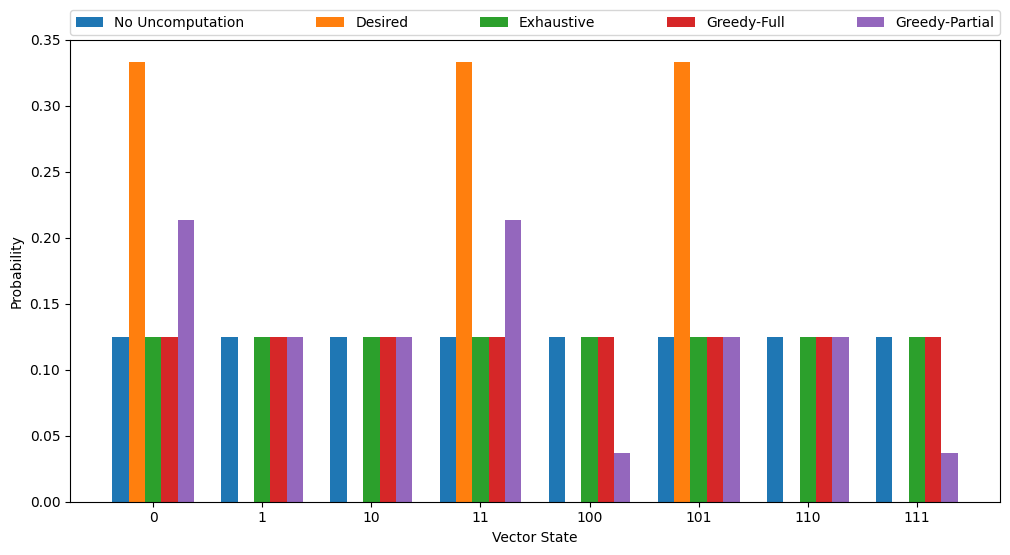

In [68]:
x = numpy.arange(len(plot_x))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 2 * width, plt_dict['no_uncomp'], width, label='No Uncomputation')
rects1 = ax.bar(x - 1 * width, plt_dict['desired'], width, label='Desired')
rects2 = ax.bar(x, plt_dict['exhaustive'], width, label='Exhaustive')
rects3 = ax.bar(x + 1 * width, plt_dict['greedy_full'], width, label='Greedy-Full')
rects4 = ax.bar(x + 2 * width, plt_dict['greedy_part'], width, label='Greedy-Partial')

ax.set_xlabel('Vector State')
ax.set_ylabel('Probability')
# ax.set_title('Multiple Bar Plots')
ax.set_xticks(x)
uni_I = ''
uni_K = ''

ax.set_xticklabels([f'{uni_I}{i}{uni_K}' for i in plot_x])
ax.legend(bbox_to_anchor=(0, 1.01, 1, 0.2), loc='lower left',
          ncol=5, mode="expand", borderaxespad=0)

# Show the plot
# plt.tight_layout()
plt.show()